# Include libraries

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.column import encode_categorical

## functions

In [2]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

## dataset loading...

In [3]:
surv_data = pd.read_csv(os.path.join('..', '..', 'data', '(v4)STROKE_VITAL_SIGN_missForest.csv'))

In [4]:
surv_data = surv_data[surv_data['CVDeath'] != 9999]

## data preprocessing

In [5]:
from sklearn import preprocessing
from sklearn_pandas import DataFrameMapper

def data_processing(data_df):
    data_df_x = data_df.drop(['LOC', 'UID', 'Mortality', 'SurvivalDays', 'CVDeath', 'SurvivalMonths',
                              'admission_date', 'discharge_date', 'death_date'], axis=1)

    data_df_y = data_df[['CVDeath', 'SurvivalDays']]

    X_temp = data_df_x[(data_df.LOC == '3') | (data_df.LOC == '2') | (data_df.LOC == '6')]
    y_temp = data_df_y[(data_df.LOC == '3') | (data_df.LOC == '2') | (data_df.LOC == '6')]
    X_df_train, X_df_val, y_df_train, y_df_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=369)

    X_df_test_kao = data_df_x[data_df.LOC == '8']
    y_df_test_kao = data_df_y[data_df.LOC == '8']

    categorical_columns = ['Sex', 'AF', 'DM', 'HTN', 'Dyslipidemia', 'CHF', 'Smoking',
                           'Cancer.before.adm']
    
    numerical_columns = np.setdiff1d(data_df_x.columns, categorical_columns).tolist()

    categorical_ix = [data_df_x.columns.get_loc(col) for col in categorical_columns]
    numerical_ix =  np.setdiff1d(list(range(0, len(data_df_x.columns))), categorical_ix).tolist()

    scaler = preprocessing.StandardScaler()

    standardize = [([col], scaler) for col in numerical_columns]
    leave = [(col, None) for col in categorical_columns]

    x_mapper = DataFrameMapper(standardize + leave)

    X_df_train = pd.DataFrame(data=x_mapper.fit_transform(X_df_train),
                              columns=numerical_columns+categorical_columns,
                              index=X_df_train.index)

    X_df_val = pd.DataFrame(data=x_mapper.fit_transform(X_df_val),
                            columns=numerical_columns+categorical_columns,
                            index=X_df_val.index)

    X_df_test_kao = pd.DataFrame(data=x_mapper.fit_transform(X_df_test_kao),
                                 columns=numerical_columns+categorical_columns,
                                 index=X_df_test_kao.index)
    # since those categorical variable are all boolen... no need to one-hot them
    # https://stackoverflow.com/questions/43515877/should-binary-features-be-one-hot-encoded
    
#     X_df_train = encode_categorical(X_df_train, columns=categorical_columns)
#     X_df_val = encode_categorical(X_df_val, columns=categorical_columns)
#     X_df_test_kao = encode_categorical(X_df_test_kao, columns=categorical_columns)
    
    return X_df_train, X_df_val, y_df_train, y_df_val, X_df_test_kao, y_df_test_kao


get_target = lambda df: (df['SurvivalDays'].values, df['CVDeath'].values)

In [6]:
X_train, X_val, y_train, y_val, X_test_kao, y_test_kao = data_processing(surv_data)

y_train_cox =  y_train.copy()
y_train_cox.loc[:, 'CVDeath'] = y_train_cox['CVDeath'].astype(bool)
y_train_cox = np.array(list(y_train_cox.to_records(index=False)))

y_test_kao_cox =  y_test_kao.copy()
y_test_kao_cox.loc[:, 'CVDeath'] = y_test_kao_cox['CVDeath'].astype(bool)
y_test_kao_cox = np.array(list(y_test_kao_cox.to_records(index=False)))

## cross validation for the best alpha

In [7]:
import warnings
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

coxnet_pipe = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01, max_iter=100)
)

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_train, y_train_cox)

estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=10, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(X_train, y_train_cox)

cv_results = pd.DataFrame(gcv.cv_results_)

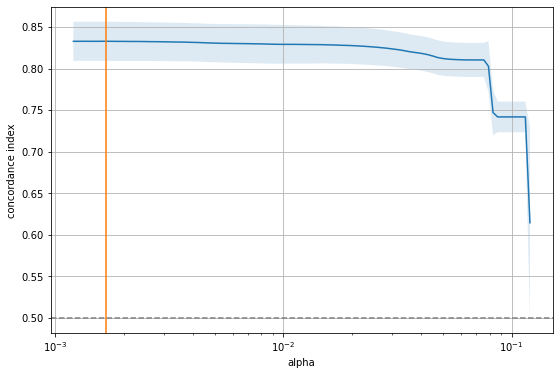

In [8]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

## The best model

In [9]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X_train.columns,
    columns=["coefficient"]
)
best_coefs.abs().sort_values(by='coefficient', ascending=False).to_csv('lasso_fs_cvd.csv')
non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

Number of non-zero coefficients: 20


In [10]:
best_model.score(X_test_kao, y_test_kao_cox)

0.8177665817018019

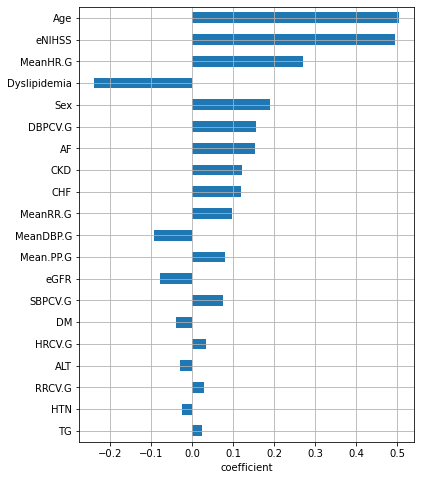

In [11]:
_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [12]:
best_model.alphas

[0.001665759412245673]

## Feature selection

In [13]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
features_list = best_coefs.abs().sort_values(by='coefficient', ascending=False).index

for i in range(len(features_list)):
    features = features_list[0:i+1]
    if len(features) > 0:
        X_train_fs = X_train[features]
        X_val_fs = X_val[features]
        X_test_kao_fs = X_test_kao[features].values.astype('float32')
        
        y_train_cox =  y_train.copy()
        y_train_cox.loc[:, 'CVDeath'] = y_train_cox['CVDeath'].astype(bool)
        y_train_cox = np.array(list(y_train_cox.to_records(index=False)))
        y_test_kao_cox =  y_test_kao.copy()
        y_test_kao_cox.loc[:, 'CVDeath'] = y_test_kao_cox['CVDeath'].astype(bool)
        y_test_kao_cox = np.array(list(y_test_kao_cox.to_records(index=False)))
        
        print(X_train_fs.shape[1])
        estimator = CoxPHSurvivalAnalysis()
        estimator.fit(X_train_fs, y_train_cox)
        print(estimator.score(X_test_kao_fs, y_test_kao_cox))      

1
0.6804806184703531
2
0.7868634234188167
3
0.7994231432549285
4
0.8021657399601666
5
0.8031453571519038
6
0.8032974605945552
7
0.8048190868632576
8
0.813090554932543
9
0.8137772102405744
10
0.8141147970253538
11
0.8161029133076663
12
0.8154067885246061
13
0.8161267053636764
14
0.8176953239022097
15
0.8174446195508202
16
0.8175587267249181
17
0.8181107971191016
18
0.818158144494246
19
0.817736752855461
20
0.8167486131361978
21
0.8167609234537353
22
0.8167592662956052
23
0.816759503032481
24
0.8167516907155822
25
0.816763764296244


## Top 5 coefficient

In [14]:
features = features_list[0:5]
X_train_fs = X_train[features]
X_val_fs = X_val[features]
X_test_kao_fs = X_test_kao[features].values.astype('float32')

y_train_cox =  y_train.copy()
y_train_cox.loc[:, 'CVDeath'] = y_train_cox['CVDeath'].astype(bool)
y_train_cox = np.array(list(y_train_cox.to_records(index=False)))
y_test_kao_cox =  y_test_kao.copy()
y_test_kao_cox.loc[:, 'CVDeath'] = y_test_kao_cox['CVDeath'].astype(bool)
y_test_kao_cox = np.array(list(y_test_kao_cox.to_records(index=False)))

print(X_train_fs.shape[1])
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train_fs, y_train_cox)
print(estimator.score(X_test_kao_fs, y_test_kao_cox))
#---
best_coefs = pd.DataFrame(
    estimator.coef_,
    index=X_train_fs.columns,
    columns=["coefficient"]
).to_csv('lasso_coef_cvd.csv')

5
0.8031453571519038
